In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from slam.gridmap import GridMap, LaserDataMatlab
from slam.utils import bresenham_line, vector2transform2D

In [3]:
plt.rcParams['figure.figsize'] = (15, 15)

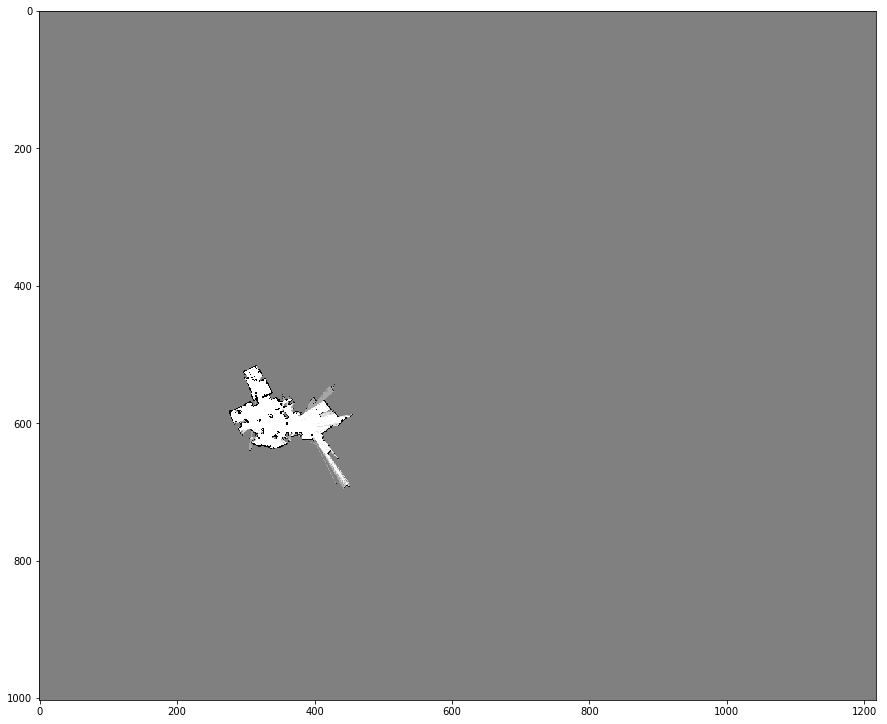

In [4]:
laser_data = LaserDataMatlab('./data/laser_struct.mat')
grid_map = GridMap(grid_size=0.1)
grid_map.init_from_laserdata(laser_data)

# Debug map
pose_list = laser_data.get_timestep_list()[:50]
# Full map (slow)
#pose_list = laser_data.get_timestep_list()
for t in pose_list:
    robot_pose = laser_data.get_pose(t)
    range_scan = laser_data.get_range_scan(t)
    grid_map.update(robot_pose, range_scan)
    
plt.imshow(grid_map.get_prob_map(), cmap='gray', interpolation='nearest')

13.315492957746478


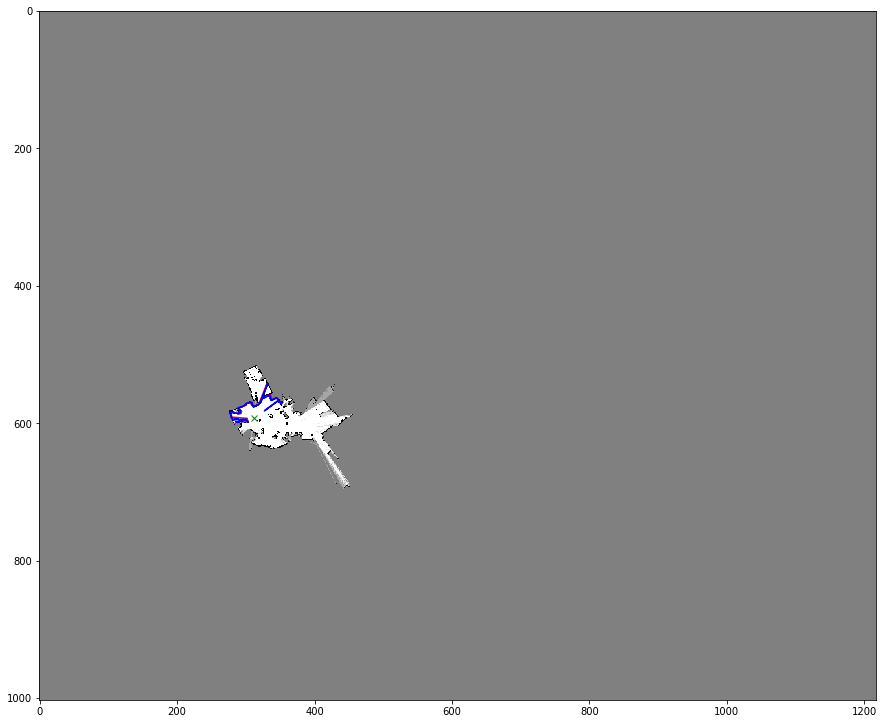

In [5]:
timestep = 25
laser_scan = laser_data.get_range_scan(timestep)
robot_pose = laser_data.get_pose(timestep)
laser_scan_b = laser_data.get_range_scan(timestep+1)
robot_pose_b = laser_data.get_pose(timestep+1)

robot_pose_map = GridMap.world_to_map_coordinates(
    robot_pose[0:2, :], grid_map._grid_size, grid_map._offset
)
rx = int(robot_pose_map.item(0))
ry = int(robot_pose_map.item(1))

robot_pose_trans = vector2transform2D(robot_pose)
real_laser_end_nt = GridMap.laser_as_cartesian(laser_scan, 30)
real_laser_end = robot_pose_trans * real_laser_end_nt
real_laser_map = GridMap.world_to_map_coordinates(
    real_laser_end[0:2, :], grid_map._grid_size, grid_map._offset
)

robot_pose_trans_b = vector2transform2D(robot_pose_b)
real_laser_end_b_nt = GridMap.laser_as_cartesian(laser_scan_b, 30)
real_laser_end_b = robot_pose_trans_b * real_laser_end_b_nt

max_range = 30
max_range = min(max_range, laser_scan['maximum_range'])
num_beams = real_laser_map.shape[1]
start_angle = laser_scan['start_angle']
angular_res = laser_scan['angular_resolution']

scan_endpoints = GridMap.generate_laser_scan(max_range, num_beams, start_angle, angular_res)
raycasted = grid_map.raycast(robot_pose, scan_endpoints, 0.49)

print(GridMap.calculate_scan_mse(raycasted, real_laser_map))
    
plt.imshow(grid_map.get_prob_map(), cmap='gray', interpolation='nearest')
plt.plot(rx, ry, 'gx')
plt.plot(raycasted[0, :], raycasted[1, :], 'r')
plt.plot(real_laser_map[0, :], real_laser_map[1, :], 'b')